In [1]:
import numpy as np
from data_cube_analysis import getdata, rms, masks, moments
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import spectral_cube
import aplpy
from math import ceil
import pyspeckit
import spectral_cube

plt.style.use('paper')

# plotting fitted gaussians
def gaussian(x, pars):
    a,b,c = pars
    return a*np.exp(-np.power(x-b, 2) / (2*np.power(c, 2)))

In [7]:
cube = spectral_cube.SpectralCube.read('/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m_bubble/h40a.12M.K.kms.galactic.fits')
cube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value = cube.hdu.header['RESTFRQ'] * u.Hz)
cube.allow_huge_operations=True

In [10]:
l = 0.824312723
b =  -0.190358071
width = 1.1719/3600
height = 1.1719/3600

region_str = "galactic; circle(%s, %s, %s\")" %(l,b,width*3600)  
sub_cube = cube.subcube_from_ds9region(region_str)

The DS9Parser class is deprecated and may be removed in a future version.
        Use `regions.Regions.parse` instead.


This function (<function BaseSpectralCube.mean at 0x7f7dd872b160>) requires loading the entire cube into memory and may therefore be slow.


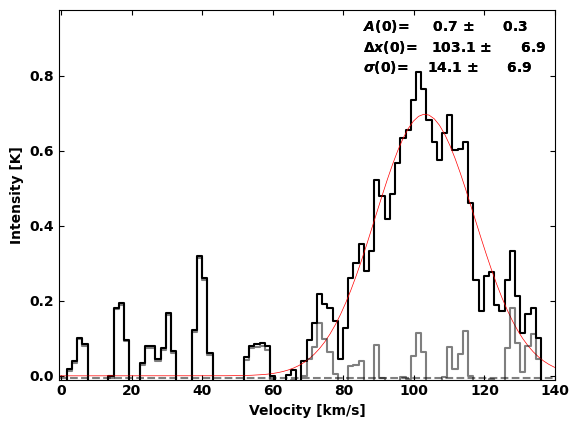

In [41]:
fig, ax = plt.subplots(1,1) 

cube_v = sub_cube.spectral_axis
mean_cube = sub_cube.mean(axis = (1, 2))

sp = pyspeckit.Spectrum(xarr = cube_v, data = mean_cube)

sp.plotter(xlabel='Velocity [km/s]', ylabel='Intensity [K]', linewidth=1.5, axis=ax, xmax=140, ymin=-0.01)
sp.specfit.multifit(fittype='gaussian', guesses=[1,100,30])
sp.specfit.plotresiduals(axis=ax, clear=False, yoffset=-0.005, label=False, linewidth=1.5, alpha=0.5)

In [42]:
def plot_cent(ax, g_fit, y, y1):
    
    cent = g_fit[1] 
    
    ax.plot([cent,cent], [y,y1], c='grey', lw=3)
    ax.text(cent+3, (y+y1)/2, '%ikm/s' %cent, ha='left', va='center', c='grey', fontsize=8, rotation=90)

    return()

def plot_fwhm(ax, g_fit, y, y1, deltav):
    
    cent = g_fit[1] 
    fwhm = np.sqrt((g_fit[2]**2)-(deltav**2)) * 2.35482  
    
    ax.plot([cent-(fwhm/2), cent+(fwhm/2)], [y,y], c='grey', lw=3)
    ax.text(cent, y1, '%0.1fkm/s' %fwhm, ha='center', va='bottom', c='grey', fontsize=8)

    return()

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


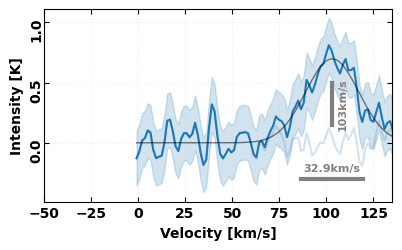

In [61]:
fig, ax = plt.subplots(1,1, figsize=(4.5,2.5))

array_v = np.arange(np.array(cube_v).min(), np.array(cube_v).max(), 1)

ax.plot(cube_v, mean_cube, label='Average')
ax.plot(cube_v, mean_cube.value-gaussian(np.array(cube_v), sp.specfit.modelpars), c='C0', alpha=0.2, label='Residual')
ax.plot(array_v, gaussian(np.array(array_v), sp.specfit.modelpars), linewidth=1, color='black', alpha=0.5, ls='-', label='Fit')

rms1 = np.nanstd(mean_cube)
ax.fill_between(cube_v.value, mean_cube.value+rms1.value, mean_cube.value-rms1.value, lw=1, alpha=0.2, zorder=-1, color='C0')

plot_fwhm(ax, sp.specfit.modelpars, -0.3, -0.25, (cube_v[1]-cube_v[0]).value)
plot_cent(ax, sp.specfit.modelpars, 0.15, 0.5)

# ax.set_xlim([0, 150])
ax.set_xlim([-50, 135])
ax.grid(':', alpha=0.2)
# ax.legend(loc='upper left')

ax.set_ylabel('Intensity [K]')
ax.set_xlabel('Velocity [km/s]')

for axis in fig.get_axes():
    axis.tick_params(axis='y', labelrotation=90, pad=0)
    
# saving figure
plt.savefig('../figures/ha_spec.pdf')